In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.optimize

import warnings
warnings.filterwarnings('ignore')

# 1 Regularized Linear Regression

## 1.1 Visualizing the dataset

In [2]:
datafile = 'data\ex5data1.mat'
data_matrix = scipy.io.loadmat(datafile)

# Training set
X, y = data_matrix['X'], data_matrix['y']
# Cross validation set
Xval, yval = data_matrix['Xval'], data_matrix['yval']
# Test set
Xtest, ytest = data_matrix['Xtest'], data_matrix['ytest']

X =     np.insert(X    ,0,1,axis=1)
Xval =  np.insert(Xval ,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)

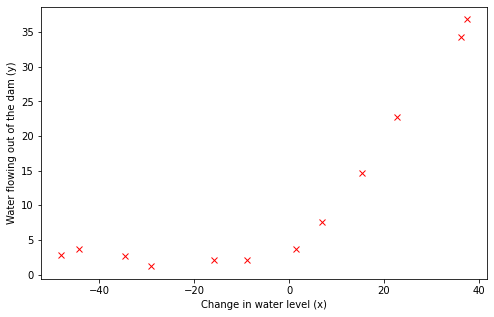

In [3]:
def plotData():
    plt.figure(figsize = (8, 5))
    plt.ylabel('Water flowing out of the dam (y)')
    plt.xlabel('Change in water level (x)')
    plt.plot(X[:, 1], y, 'rx')

plotData()

## 1.2 Regularized linear regression cost function

In [4]:
# Hypothesis function
def h(theta, X):
    return np.dot(X, theta)

# Cost function
def cost(theta, X, y, mylambda = 0.):
    m = X.shape[0]
    tmp = h(theta, X).reshape((m, 1))
    cost = np.dot((tmp - y).T, tmp - y)
    reg = mylambda * np.dot(theta[1:].T, theta[1:])
    return float((1 / (2 * m)) * (cost + reg))

In [5]:
theta_init = np.array([[1.], [1.]])
print(cost(theta_init, X, y, 1.))

303.9931922202643


## 1.3 Regularized linear regression gradient

In [6]:
def costGrad(theta, X, y, mylambda = 0.):
    m = X.shape[0]
    tmp = h(theta, X).reshape((m, 1))
    grad = (1. / float(m)) * np.dot(X.T, tmp - y)
    reg = (float(mylambda) / m) * theta
    reg[0] = 0 # Ignore theta[0]
    reg.resize((grad.shape[0], 1))
    return grad + reg

def costGradFlt(theta, X, y, mylambda = 0.):
    return costGrad(theta, X, y, mylambda = 0.).flatten()

In [7]:
print(costGrad(theta_init, X, y, 1.))

[[-15.30301567]
 [598.25074417]]


## 1.4 Fitting linear regression

In [8]:
def fitTheta(theta, X, y, mylambda = 0., output = True):
    theta_fit = scipy.optimize.fmin_cg(cost, x0 = theta, fprime = costGradFlt, args = (X, y, mylambda),\
                                       disp = output, epsilon = 1.49e-12, maxiter = 1000)
    return theta_fit.reshape((theta.shape[0], 1))

In [9]:
Theta = fitTheta(theta_init, X, y, 0.)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


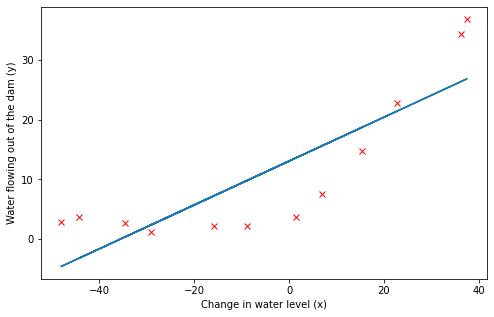

In [10]:
plotData()
plt.plot(X[:, 1], h(Theta, X))

# 2 Bias-variance

## 2.1 Learning curves

In [11]:
def plotLearningCurve():
    X_n, error_train, error_val = [], [], []
    for i in range(1, 13, 1):
        X_sub = X[:i, :]
        y_sub = y[:i]
        X_n.append(X_sub.shape[0])
        theta_fit = fitTheta(theta_init, X_sub, y_sub, mylambda = 0., output = False)
        error_train.append(cost(theta_fit, X_sub, y_sub, mylambda = 0.))
        error_val.append(cost(theta_fit, Xval, yval, mylambda = 0.))
        
    plt.figure(figsize = (8, 5))
    plt.plot(X_n, error_train, label = 'Train')
    plt.plot(X_n, error_val, label = 'Cross Validation')
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.grid(True)

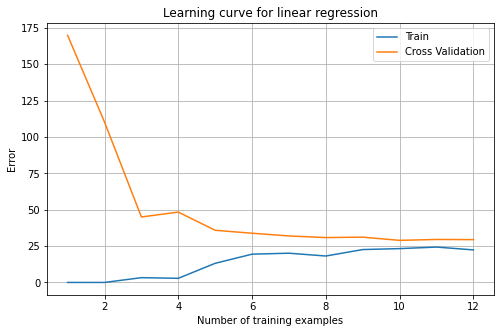

In [12]:
plotLearningCurve()

# 3 Polynomial regression

In [13]:
def mapFeature(X, p):
    X_mapped = X.copy()
    for i in range(p):
        dim = i + 2
        X_mapped = np.insert(X_mapped, X_mapped.shape[1], np.power(X_mapped[:, 1], dim), axis = 1)
    return X_mapped

def featureNormlize(X):
    X_norm = X.copy()
    feature_mean = np.mean(X_norm, axis = 0)
    X_norm[:, 1:] = X_norm[:, 1:] - feature_mean[1:]
    feature_std = np.std(X_norm, axis = 0, ddof = 1)
    X_norm[:, 1:] = X_norm[:, 1:] / feature_std[1:]
    return X_norm, feature_mean, feature_std

## 3.1 Learning Polynomial Regression

In [14]:
dim = 5
X_mapped = mapFeature(X, dim)
X_norm, feature_mean, feature_std = featureNormlize(X_mapped)
theta_init = np.ones((X_norm.shape[1], 1))
theta_fit = fitTheta(theta_init, X_norm, y, 0.)

Optimization terminated successfully.
         Current function value: 0.198053
         Iterations: 158
         Function evaluations: 300
         Gradient evaluations: 300


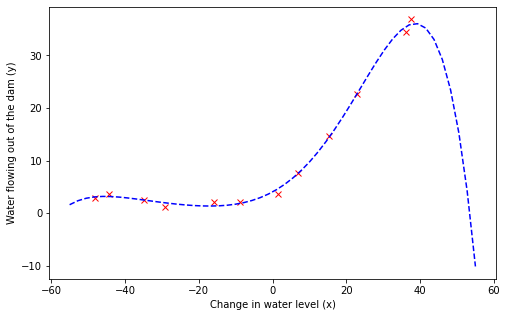

In [15]:
def plotFit(theta, mean, std):
    n = 50
    xval = np.linspace(-55, 55, n)
    xmat = np.ones((n, 1))
    
    xmat = np.insert(xmat, xmat.shape[1], xval, axis = 1)
    xmat = mapFeature(xmat, len(theta) - 2)
    xmat[:, 1:] = xmat[:, 1:] - mean[1:]
    xmat[:, 1:] = xmat[:, 1:] / std[1:]
    plotData()
    plt.plot(xval, h(theta, xmat), 'b--')
    
plotFit(theta_fit, feature_mean, feature_std)

In [23]:
def plotPolyLearningCurve(mylambda = 0.):
    X_n, error_train, error_val = [], [], []
    Xval_mapped, dummy1, dummy2 = featureNormlize(mapFeature(Xval, dim))
    
    for i in range(1, 13, 1):
        X_sub = X[:i, :]
        y_sub = y[:i]
        X_n.append(X_sub.shape[0])
        X_sub_mapped = mapFeature(X_sub, dim)
        X_sub_mapped, dummy1, dummy2 = featureNormlize(X_sub_mapped)
        theta_fit = fitTheta(theta_init, X_sub_mapped, y_sub, mylambda = mylambda, output = False)
        error_train.append(cost(theta_fit, X_sub_mapped, y_sub, mylambda = mylambda))
        error_val.append(cost(theta_fit, Xval_mapped, yval, mylambda = mylambda))
        
    plt.figure(figsize = (8, 5))
    plt.plot(X_n, error_train, label = 'Train')
    plt.plot(X_n, error_val, label = 'Cross Validation')
    plt.legend()
    plt.title('Polynomial Regression Learning Curve (lambda = 0)')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.ylim([0, 100])
    plt.grid(True)

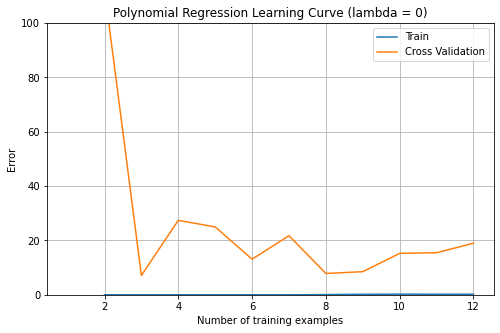

In [24]:
plotPolyLearningCurve()

## 3.2 Optional: Adjusting the regularization parameter

         Current function value: 8.107152
         Iterations: 6
         Function evaluations: 59
         Gradient evaluations: 47


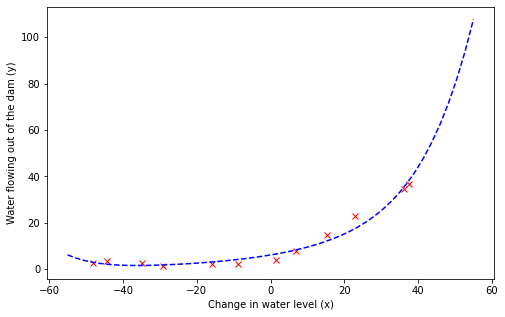

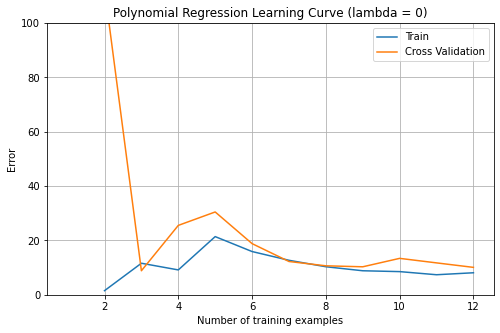

In [25]:
theta_fit = fitTheta(theta_init, X_norm, y, 1)
plotFit(theta_fit, feature_mean, feature_std)
plotPolyLearningCurve(1.)

         Current function value: 132.266064
         Iterations: 0
         Function evaluations: 39
         Gradient evaluations: 27


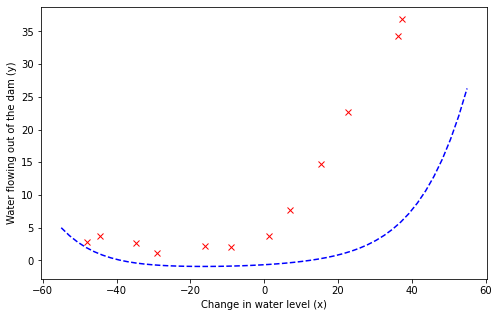

In [26]:
theta_fit = fitTheta(theta_init, X_norm, y, 100)
plotFit(theta_fit, feature_mean, feature_std)

## 3.3 Selecting  Î» using a cross validation set

In [27]:
X_new = mapFeature(X, dim)
X_new_norm, dummy1, dummy2 = featureNormlize(X_norm)
Xval_new = mapFeature(Xval, dim)
Xval_new_norm, dummy1, dummy2 = featureNormlize(Xval_new)

lambdas = np.linspace(0, 5, 20)
error_train, error_val = [], []
for ilambda in lambdas:
    theta_fit = fitTheta(theta_init, X_new_norm, y, ilambda, False)
    error_train.append(cost(theta_fit, X_new_norm, y, mylambda = ilambda))
    error_val.append(cost(theta_fit, Xval_new_norm, yval, mylambda = ilambda))

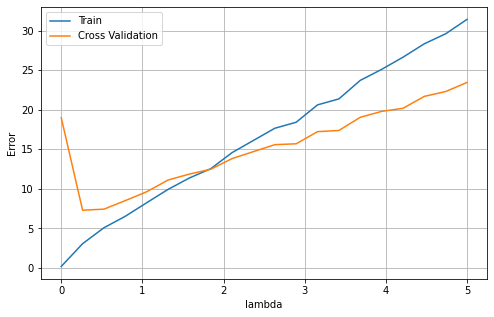

In [29]:
plt.figure(figsize = (8, 5))
plt.plot(lambdas, error_train, label = 'Train')
plt.plot(lambdas, error_val, label = 'Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Error')
plt.grid(True)